In [1]:
import pandas as pd
import numpy as np
import os
import numpy
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

## Define some generally useful functions

In [2]:
def calculate_regression_line(x, y):
    """
    Calculates the regression line between two 1-dimensional vectors using scikit-learn.

    Parameters:
    x (numpy array or list): The independent variable vector.
    y (numpy array or list): The dependent variable vector.

    Returns:
    tuple: A tuple containing the slope and intercept of the regression line.
    """
    # Convert the input vectors to numpy arrays if they are not already
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)

    # Fit the linear regression model
    regression_model = LinearRegression()
    regression_model.fit(x, y)

    # Extract the slope and intercept of the regression line
    slope = regression_model.coef_[0]
    intercept = regression_model.intercept_

    return slope, intercept

## Define locations

In [3]:
loc_medical_costs = os.path.join('..', 'data', 'insurance.csv')

## Read data

In [4]:
df_medical_costs = pd.read_csv(loc_medical_costs)

## Perform linear regression only based on age

In [5]:
df_medical_costs.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<AxesSubplot:xlabel='age', ylabel='charges'>

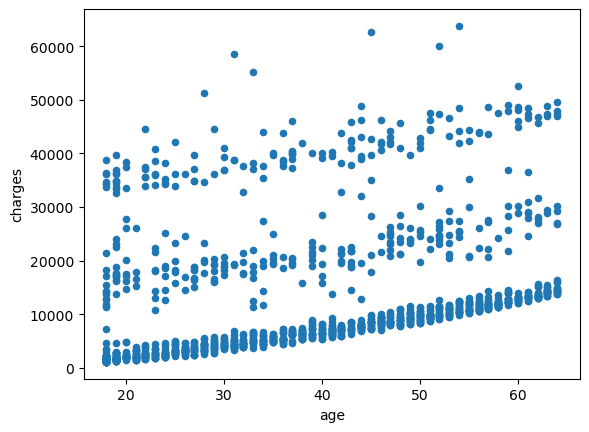

In [6]:
df_medical_costs.plot.scatter(x = 'age', y = 'charges')

## Plotting the cost function

In [7]:
def compute_rmse(yhat, y):
    """
    Computes the root mean squared error (RMSE) between yhat and y.

    Parameters:
        yhat (array-like): Predicted values.
        y (array-like): True values.

    Returns:
        float: Root mean squared error (RMSE).
    """
    # Convert yhat and y to numpy arrays
    yhat = np.array(yhat)
    y = np.array(y)

    # Compute the squared error
    squared_error = np.abs(yhat - y) ** 2

    # Compute the mean squared error
    mean_squared_error = np.mean(squared_error)

    # Compute the root mean squared error
    rmse = np.sqrt(mean_squared_error)

    return rmse

def evaluate_model(x, slope, intercept):

    return intercept + slope * x

In [8]:
ages = df_medical_costs['age']
charges = df_medical_costs['charges']

slope_opt, intercept_opt = calculate_regression_line(ages, charges)

theta_0_range = np.linspace(0, intercept_opt * 2)
theta_1_range = np.linspace(0, slope_opt * 2)

theta_0_grid, theta_1_grid = np.meshgrid(theta_0_range, theta_1_range)

# This is highly inefficient as we will see further on (we should vectorize these computations).
model_values = np.zeros( (len(theta_0_range), len(theta_1_range), len(ages)) )
model_performance = np.zeros( (len(theta_0_range), len(theta_1_range)) )

for i, theta_0 in tqdm(enumerate(theta_0_range)):
    for j, theta_1 in enumerate(theta_1_range):
        for k, age in enumerate(ages):
            model_values[i, j, k] = evaluate_model(age, theta_1, theta_0)
        model_performance[i, j] = compute_rmse(model_values[i, j, :], charges)

50it [00:02, 19.76it/s]


## RMSE visualized

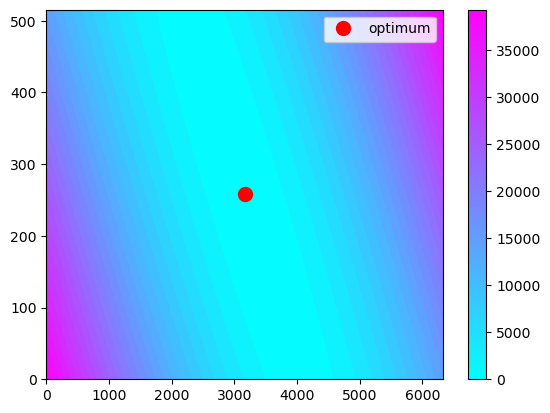

In [9]:
fig, ax = plt.subplots()

norm = colors.Normalize(vmin=np.min(model_values), vmax=np.max(model_values))
scalar_map = cm.ScalarMappable(norm=norm, cmap='cool')
ax.contourf(theta_0_grid, theta_1_grid, model_performance, levels = 30, cmap = 'cool')
cbar = plt.colorbar(scalar_map, ax = ax)

ax.plot([intercept_opt], [slope_opt], color = 'r', marker = '.', markersize = 20, label = 'optimum', ls = '')
ax.legend()

## Alternative error functions

In [10]:
yhat = slope_opt * ages + intercept_opt
MAE = np.mean(np.abs(yhat - charges))
MPE = np.mean(np.abs(yhat - charges) / yhat)


## Visualize erros

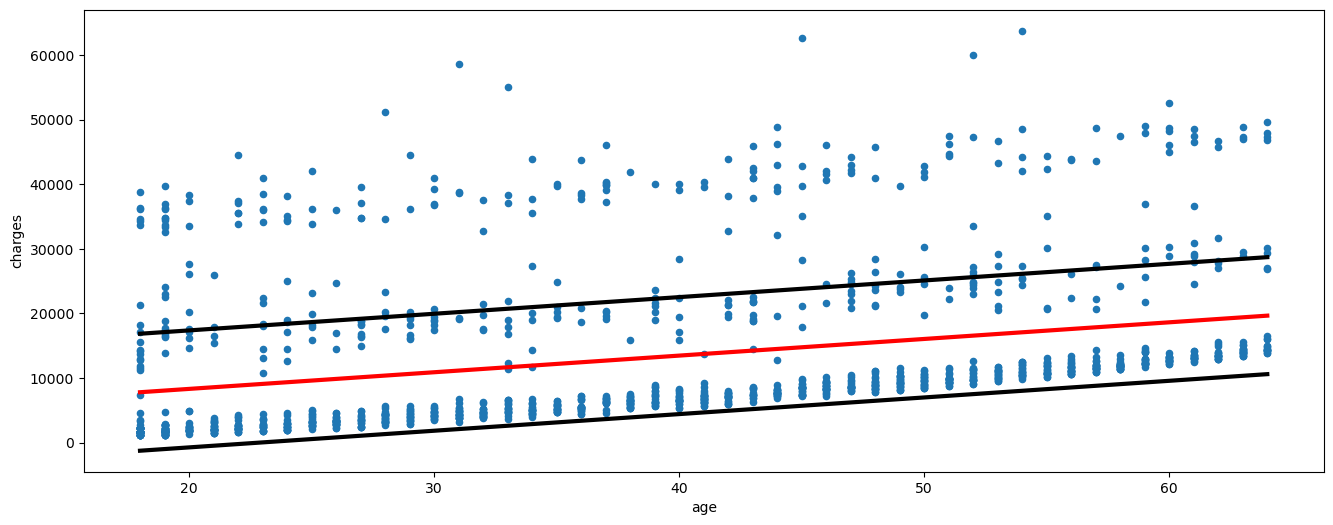

In [11]:
fig, ax = plt.subplots(figsize = (16, 6))
df_medical_costs.plot.scatter(x = 'age', y = 'charges', ax = ax)

xx = np.linspace(df_medical_costs.age.min(), df_medical_costs.age.max(), num = 100)
yy = intercept_opt + slope_opt * xx
ax.plot(xx, yy, color = 'r', lw = 3)
ax.plot(xx, yy - MAE, color = 'k', lw = 3)
ax.plot(xx, yy + MAE, color = 'k', lw = 3)

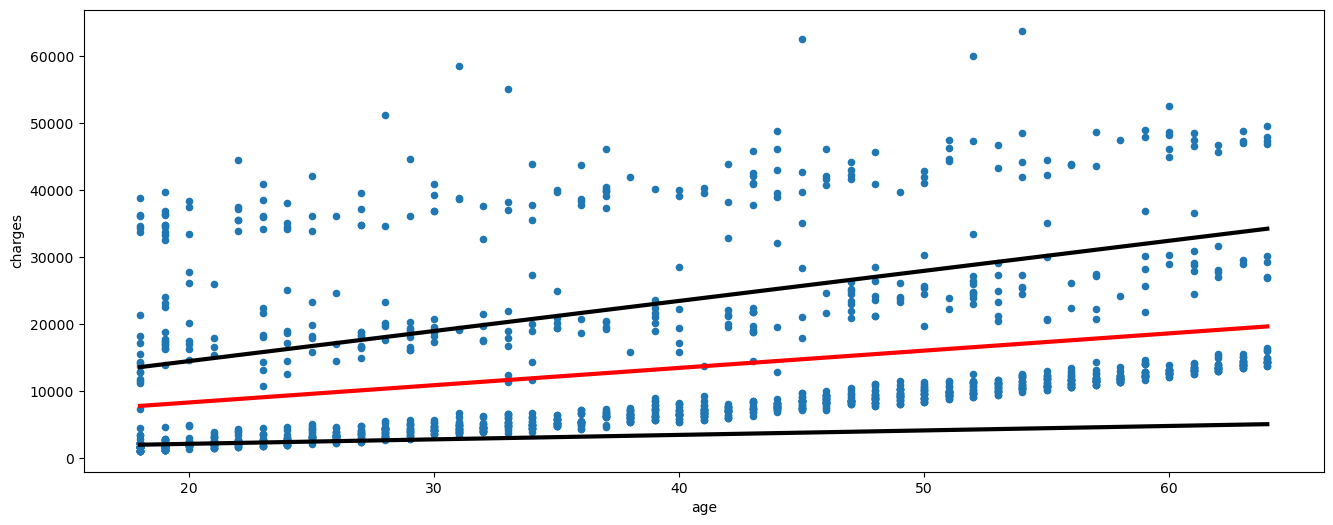

In [12]:
fig, ax = plt.subplots(figsize = (16, 6))
df_medical_costs.plot.scatter(x = 'age', y = 'charges', ax = ax)

xx = np.linspace(df_medical_costs.age.min(), df_medical_costs.age.max(), num = 100)
yy = intercept_opt + slope_opt * xx
ax.plot(xx, yy, color = 'r', lw = 3)
ax.plot(xx, yy * (1 + MPE), color = 'k', lw = 3)
ax.plot(xx, yy * (1 - MPE), color = 'k', lw = 3)

(0.0, 60000.0)

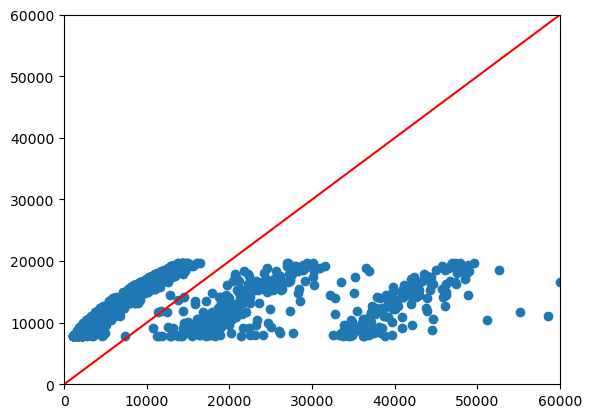

In [13]:
charges_pred = intercept_opt + slope_opt * ages

plt.scatter(x = charges, y = charges_pred)
plt.plot([0, 60000], [0, 60000], color = 'r')
plt.xlim([0, 60000])
plt.ylim([0, 60000])

## Splitting the data based on additional features

In [14]:
def categorize_bmi(bmi):

    if bmi < 18:
        return 'low'
    elif bmi <= 24:
        return 'normal'
    else:
        return 'high'
    
df_medical_costs['bmi_categories'] = pd.Categorical( df_medical_costs['bmi'].apply(categorize_bmi), categories = ['low', 'normal', 'high'] )

<AxesSubplot:xlabel='age', ylabel='bmi'>

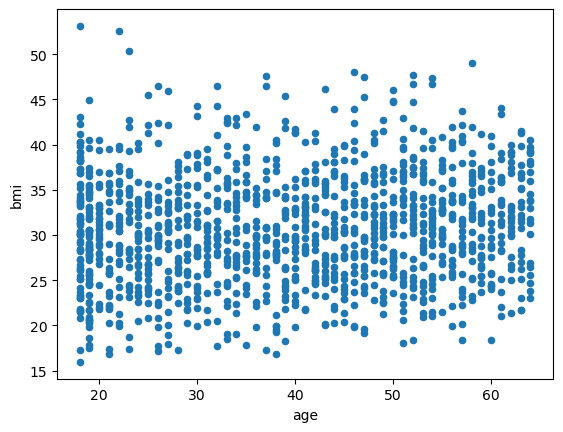

In [15]:
df_medical_costs.plot.scatter(x = 'age', y = 'bmi')

In [16]:
df_medical_costs = df_medical_costs.query("sex == 'female'")

In [17]:
df_medical_costs

,age,sex,bmi,children,smoker,region,charges,bmi_categories
0,19,female,27.90,0,yes,southwest,16884.92400,high
5,31,female,25.74,0,no,southeast,3756.62160,high
6,46,female,33.44,1,no,southeast,8240.58960,high
7,37,female,27.74,3,no,northwest,7281.50560,high
9,60,female,25.84,0,no,northwest,28923.13692,high
...,...,...,...,...,...,...,...,...
1332,52,female,44.70,3,no,southwest,11411.68500,high
1334,18,female,31.92,0,no,northeast,2205.98080,high
1335,18,female,36.85,0,no,southeast,1629.83350,high
1336,21,female,25.80,0,no,southwest,2007.94500,high


<AxesSubplot:xlabel='children'>

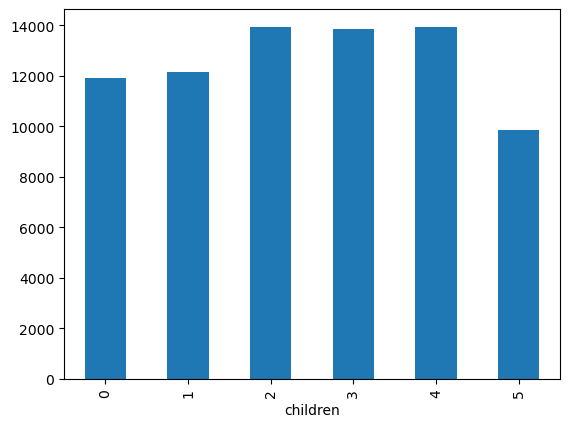

In [18]:
categories = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'bmi_categories']

fig, ax = plt.subplots()
df_medical_costs.groupby(categories[3])['charges'].mean().plot.bar()

## Split the data based on smoker & train new models

In [43]:
df_medical_costs_smokers = df_medical_costs.query("smoker == 'yes'")
df_medical_costs_non_smokers = df_medical_costs.query("smoker == 'no'")

In [44]:
# Build model smokers
ages_smokers = df_medical_costs_smokers['age']
charges_smokers = df_medical_costs_smokers['charges']

slope_smokers, intercept_smokers = calculate_regression_line(ages_smokers, charges_smokers)

# Build model non smokers
ages_ns = df_medical_costs_non_smokers['age']
charges_ns = df_medical_costs_non_smokers['charges']

slope_ns, intercept_ns = calculate_regression_line(ages_ns, charges_ns)

def model_linreg_class_smoking(sample, slope_smokers, intercept_smokers, slope_ns, intercept_ns):

    if sample['smoker'] == 'yes':
        return intercept_smokers + slope_smokers * sample['age']
    else:
        return intercept_ns + slope_ns * sample['age']
    
pred_smoke_model = [model_linreg_class_smoking(sample, slope_smokers, intercept_smokers, slope_ns, intercept_ns) for _, sample in df_medical_costs.iterrows()]

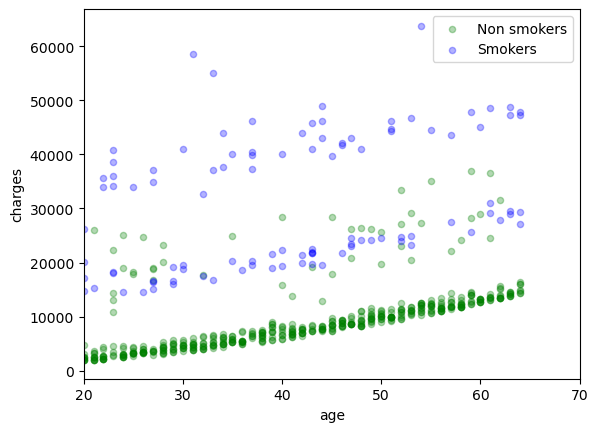

In [48]:
colors = ['green', 'blue', 'red']
fig, ax = plt.subplots()

chosen_category = 'smoker'

for n, (idx, group) in enumerate(df_medical_costs.groupby(chosen_category)):
    if idx == 'yes':
        group.plot.scatter(x = 'age', y = 'charges', ax = ax, color = colors[n], alpha = 0.3, label = 'Smokers')
    else:
        group.plot.scatter(x = 'age', y = 'charges', ax = ax, color = colors[n], alpha = 0.3, label = 'Non smokers')

xx = np.linspace(0, 80)
#ax.plot(xx, intercept_smokers + slope_smokers * xx, color = 'b', label = 'smokers')
#ax.plot(xx, intercept_ns + slope_ns * xx, color = 'g', label = 'non smokers')

ax.set_xlim([20, 70])
ax.legend()

(0.0, 60000.0)

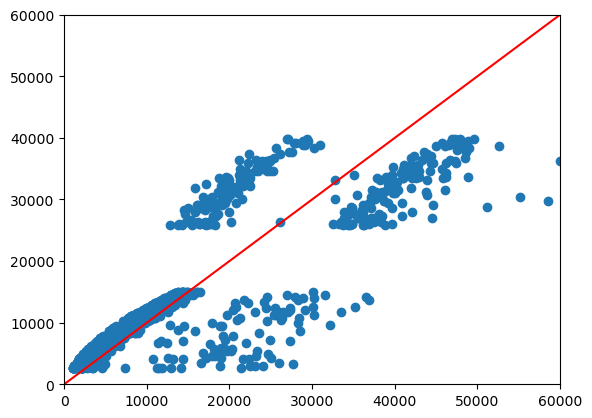

In [ ]:
plt.scatter(x = charges, y = pred_smoke_model)
plt.plot([0, 60000], [0, 60000], color = 'r')
plt.xlim([0, 60000])
plt.ylim([0, 60000])

In [ ]:
compute_rmse(charges, np.mean(charges) * np.ones_like(charges)) # = std

12105.484975561612

In [ ]:
compute_rmse(charges, charges_pred)

11551.66562075632

In [ ]:
compute_rmse(charges, pred_smoke_model)

6386.005455197869

## Split smokers

In [21]:
df_medical_costs['yearly_charges'] = df_medical_costs['charges'] / df_medical_costs['age']

C:\Users\timH\AppData\Local\Temp\ipykernel_43828\203571899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_costs['yearly_charges'] = df_medical_costs['charges'] / df_medical_costs['age']


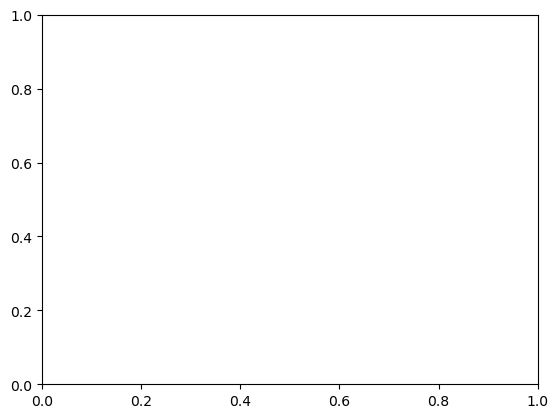

In [22]:
fig, ax = plt.subplots()


Text(0.5, 0, 'Yearly medical charges')

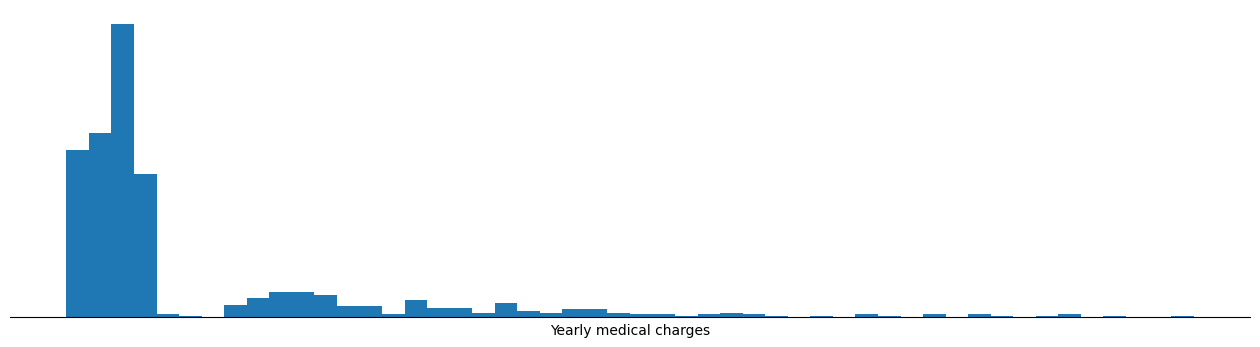

In [40]:
# Sample data

fig, ax = plt.subplots(figsize = (16, 4))

# Create a density histogram
ax.hist(df_medical_costs['yearly_charges'], bins=50, density=True)

# Remove labels and lines
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add x-axis label
ax.set_xlabel("Yearly medical charges")

Text(0.5, 0, 'Yearly medical charges')

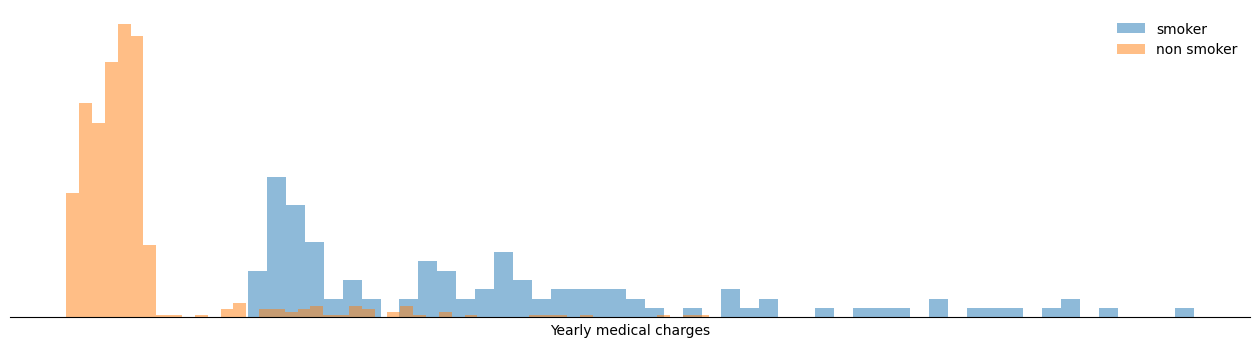

In [42]:
# Sample data

fig, ax = plt.subplots(figsize = (16, 4))

# Create a density histogram
ax.hist(df_medical_costs.query("smoker == 'yes'")['yearly_charges'], bins=50, density=True, alpha = 0.5, label = 'smoker')
ax.hist(df_medical_costs.query("smoker == 'no'")['yearly_charges'], bins=50, density=True, alpha = 0.5, label = 'non smoker')

# Remove labels and lines
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

plt.legend(frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add x-axis label
plt.xlabel("Yearly medical charges")